# AutoEncoder of Touchalytics Data

-- Touchalytics uses users' touch data (up-down and left-right scrolling) when interacting with an app. It uses the collected touch data for user authentication. The system uses 30 behavioral features and data from 41 users. We downloaded touchalytics data from the link http://www.mariofrank.net/touchalytics/. We then cleaned the data by replacing 'NaN' and 'Infinity' by zero and dropped the 'doc id', 'phone id', and 'change of finger orientation' columns.

-- We used oversampled data for AutoEncoder

-- We then measure the difference between an input vector and recovered vector of AutoEncoder.

In [7]:
#import all necessary package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
#use tensorflow version 1.x
%tensorflow_version 1.x

In [18]:
#read all oversampled data
import csv
import pandas as pd
with open('Data/AllOversampledNTData.csv') as csvfile:
    dataSet = list(csv.reader(csvfile, delimiter=','))
dfdataSet = pd.DataFrame(dataSet[0:][:])
dfdataSet.columns=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19',
            'F20','F21','F22','F23','F24','F25','F26','F27','F28','F29','F30','ID']
print('Successfully read all data..')

Successfully read all data..


In [19]:
#Use dataframe and set column name
import numpy as np
import random
from sklearn.utils import shuffle
columnsN=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19',
            'F20','F21','F22','F23','F24','F25','F26','F27','F28','F29','F30','ID']
columnsF=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19',
            'F20','F21','F22','F23','F24','F25','F26','F27','F28','F29','F30']

fdataSet = pd.DataFrame(columns = columnsN)

#print(fdataSet)
for i in range (0,41):
  #fdataSet=fdataSet.append(shuffle(dfdataSet[1000*(i-1):i*1000]),ignore_index = True)
  fdataSet=fdataSet.append(dfdataSet[2000*i+1:(i+1)*2000+1])

fDataSet=fdataSet.drop(columns=['ID'])
#fDataSet=standardize(fDataSet,columns=columnsF)

fIDSet = pd.DataFrame(columns = ['ID'])
fIDSet=fdataSet['ID']
for i in range (0,41):
  fIDSet[2000*i:(i+1)*2000]=i

#fDataSet['ID'] = fIDSet

In [20]:
#Seperate the oversampled data in [tranning set, validation set and test set] of all users
import numpy as np
from numpy import array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X1=fDataSet[:39999]
y1=fIDSet[:39999]
X2=fDataSet[40000:79999]
y2=fIDSet[40000:79999]
y2=y2-20

#print(y1.shape)
#print(X2)
#print(y2)

#Divide first 97 uses data in tranning set, validation set and test set for 97 users
#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=22,stratify=y1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=22)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.2, random_state=22)

y1_train = to_categorical(y1_train)
y1_val = to_categorical(y1_val)
y1_test = to_categorical(y1_test)

#Divide next 97 uses data in tranning set, validation set and test set for 97 users
#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=22,stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=22)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.2, random_state=22)

y2T=y2_train
y2V=y2_val
y2Te=y2_test
y2_train = to_categorical(y2_train)
y2_val = to_categorical(y2_val)
y2_test = to_categorical(y2_test)

In [21]:
#print the shape of training, test and validation data
print(X2_train.shape)
print(X2_val.shape)
print(X2_test.shape)

(25599, 30)
(6400, 30)
(8000, 30)


In [22]:
#import necessary packages for autoencoder
from keras.layers import Dense, Dropout, Input,Activation,Dropout, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [26]:
#Construct an autoencoder
input_data = Input(shape=(30,))
encoded = Dense(25, activation='relu')(input_data)
#encoded = Dense(10, activation='relu')(encoded)
#encoded = Dense(2, activation='relu')(encoded)

#decoded = Dense(10, activation='relu')(encoded)
#decoded = Dense(20, activation='relu')(decoded)
decoded = Dense(30, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

In [27]:
#Seperate the decoder
encoder = Model(input_data, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(25,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [30]:
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.fit(X2_train, X2_train, epochs=50, batch_size=256, shuffle=True,validation_data=(X2_val, X2_val))

Train on 25599 samples, validate on 6400 samples
Epoch 1/50
25599/25599 [==============================] - 1s 39us/step - loss: 0.0600 - val_loss: 0.0185
Epoch 2/50
25599/25599 [==============================] - 1s 35us/step - loss: 0.0165 - val_loss: 0.0150
Epoch 3/50
25599/25599 [==============================] - 1s 35us/step - loss: 0.0151 - val_loss: 0.0142
Epoch 4/50
25599/25599 [==============================] - 1s 34us/step - loss: 0.0143 - val_loss: 0.0135
Epoch 5/50
25599/25599 [==============================] - 1s 34us/step - loss: 0.0136 - val_loss: 0.0128
Epoch 6/50
25599/25599 [==============================] - 1s 35us/step - loss: 0.0129 - val_loss: 0.0121
Epoch 7/50
25599/25599 [==============================] - 1s 35us/step - loss: 0.0122 - val_loss: 0.0115
Epoch 8/50
25599/25599 [==============================] - 1s 34us/step - loss: 0.0116 - val_loss: 0.0109
Epoch 9/50
25599/25599 [==============================] - 1s 35us/step - loss: 0.0111 - val_loss: 0.0104
Epoch 

In [31]:
# encode and decode the test data
encoded_data = encoder.predict(X2_test)
decoded_data = decoder.predict(encoded_data)

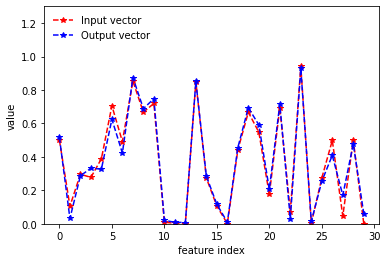

In [32]:
#Show the difference between input and recovered vector
import matplotlib.pyplot as plt
#plt.style.use('classic')
#matplotlib inline
import pandas as pd
import numpy as np
i=300
X2_Out=autoencoder.predict(X2_test)

Y2=X2_test[i:i+1].values
Y2=Y2.reshape(-1)
Yi2=Y2.astype(float)

Xl = [i for i in range(30)]
Y1=array(X2_Out[i:i+1])
Yo1=Y1.reshape(-1)

plt.plot(Xl,Yi2,'--*r',label='Input vector')
plt.plot(Xl,Yo1,'--*b', label='Output vector')
#plt.plot(X1,Y11,'--g', label='Predicted value')

plt.legend(loc='upper left', frameon=False)
plt.ylim([0,1.3])
plt.xlabel('feature index')
plt.ylabel('value')
plt.show()